### Non-Parametric (Historical) Monte-Carlo VaR 

In [242]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf 
import matplotlib.pyplot as plt
from scipy.stats import norm 

#### Necessary functions

In [357]:
def log_returns(closed_price):
    """
    Calculate time series log return: Parameters  
    closed_price = closed price 
    """
    log_return = np.log(closed_price/closed_price.shift(1))
    log_return = log_return.dropna()
    return log_return

def portfolio_expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

def weights_type(method,ticker):
    """
    method type = 1. price_weight, 2. equal_weight, 3. market_cap_weight
    """
    if method == 'price_weight':
        weights = np.array([1/len(ticker)]*len(ticker))
    
    return weights

def portfolio_st_dev(weights, returns):
    """
    returns = time series log_returns 
    weights = log_returns
    
    """
    cov_matrix = returns.cov()
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def scenario_gain_loss(portfolio_value,portfolio_expected_return, portfolio_std_dev, z_score, days): 
    """
    Calculate stochastic normal random return
    """
    return (portfolio_value * (( portfolio_expected_return * days) + (portfolio_std_dev * z_score *np.sqrt(days))))

def extract_data(tickers, price='Adj Close', years =10, end=dt.datetime.now()):
    """
    Extract stock data from YF: 
    
    tickers = tickers of stock
    price = column names from yf.download (default: 'Adj Close')
    years = Select historcial years  (default: 10 years)
    end = Select the latest stock price (default: today) 
    
    """
    
    start = end-dt.timedelta(days=365*years)
    
    adj_close_df = pd.DataFrame()
    
    for ticker in tickers:
        data = yf.download(ticker, start, end)
        adj_close_df[ticker] = data[price]
        
    return adj_close_df

def plot_historical_VaR(scenario_returns_list, VaR, confidence_interval, days, time_series_data=None):
    
    figs, (var_plot, ts_plot) = plt.subplots(nrows=1, ncols=2, figsize=(13,5)) 
    
    var_plot.hist(scenario_returns_list,bins=50,density=True,color='Green')
    
    var_plot.set_xlabel('Potential lognormal gain/loss in $')
    var_plot.set_ylabel('Frequencies')
    var_plot.axvline(VaR,color='r',linestyle='dashed',linewidth=2,label=f'VaR at {confidence_interval} confidence level')
    var_plot.set_title(f'distribution VaR:{np.round(VaR,decimals=2)} ($) for {days} days at {confidence_interval}')


## f'Distribution of P/F lognormal gains over {days} with VaR:{np.round(VaR,decimals=2)}'
    if time_series_data is not None: 
        ts_plot.plot(time_series_data)
        ts_plot.set_xlabel('Date')
        ts_plot.set_ylabel('Share Price')
        ts_plot.set_title('Time Series Return of P/F ($)')
        
    figs.suptitle('Distributions')
    
    plt.show()

### Select Parameters

In [367]:
ticker = ['SPY']
value_of_portfolio = 1000
price_type = 'Adj Close' ## Options: Open, High, Low, Adj Close, Volumne
weight_type = 'price_weight' ##Options: 1. price_weight, 2. equal_weight, 3. market_cap_weight

## Based on 
years = 10
days = 30
Number_of_random_simulation = 100000
confidence_interval = 0.99
distribution = 'z_score'

### Run the calculation with result

[*********************100%%**********************]  1 of 1 completed


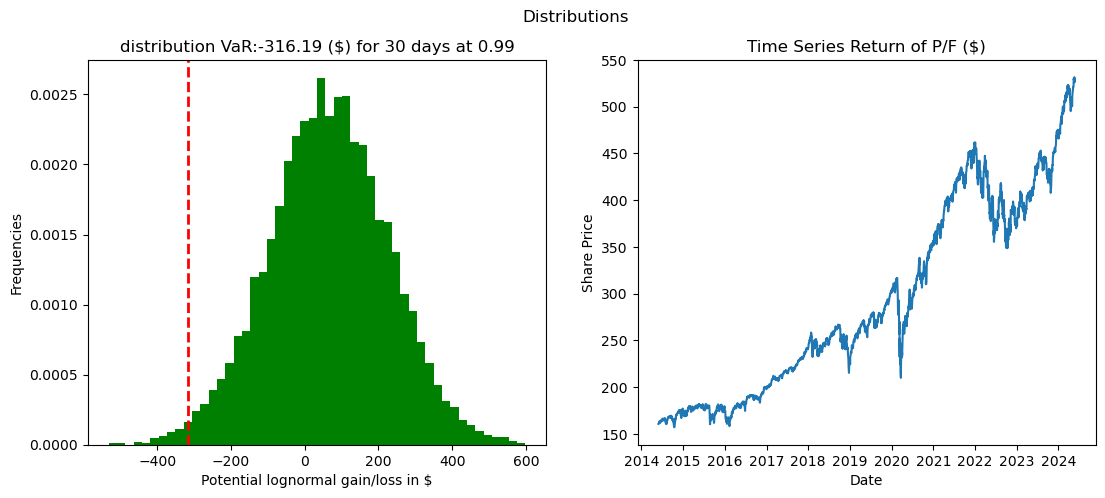

In [369]:
start = dt.datetime.now() - dt.timedelta(days=365*years)
data = yf.download(ticker, start, dt.datetime.now())

historical_returns_df = log_returns(adj_price)
weights = weights_type(weight_type, ticker = ticker)

pf_daily_expected_return = portfolio_expected_return(weights,historical_returns_df)
pf_daily_std = portfolio_st_dev(weights, historical_returns_df)

scenario_return_list = [] 
for i in range(simulations):
    if distribution == 'z_score':
        z_score = np.random.normal(0,1)
        scenario_return_list.append(scenario_gain_loss(portfolio_value=value_of_portfolio,portfolio_expected_return=pf_daily_expected_return,
                                                portfolio_std_dev= pf_daily_std,z_score=z_score,days=days))
    else:
        raise ValueError ('Currently only z_score is avaiable')

VaR = np.percentile(scenario_return_list, 100*(1-confidence_interval))

plot_historical_VaR(scenario_return_list, VaR, confidence_interval, days, time_series_data = data[price_type])

#### Step by step calculation as below

In [351]:
start = dt.datetime.now() - dt.timedelta(days=365*years)
data = yf.download(ticker, start, dt.datetime.now())
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-29,191.820007,192.399994,191.330002,192.369995,160.765411,64377000
2014-05-30,192.190002,192.800003,192.029999,192.679993,161.024475,76316000
2014-06-02,192.949997,192.990005,191.970001,192.899994,161.208328,64656000
2014-06-03,192.429993,192.899994,192.250000,192.800003,161.124786,65047000
2014-06-04,192.470001,193.300003,192.270004,193.190002,161.450760,55529000


In [266]:
data.loc[:,['Adj Close']].head()

,Adj Close
Date,
2023-05-30,400.981354
2023-05-31,378.218689
2023-06-01,397.572510
2023-06-02,393.143921
2023-06-05,391.584412


In [267]:
## Calculate historical portfolio log-returns, std. 
historical_returns_df = log_returns(data.loc[:,[price_type]])
weights = np.array([1/len(tickers)]*len(tickers))
pf_daily_expected_return = portfolio_expected_return(weights,historical_returns_df)
pf_daily_std = portfolio_st_dev(weights, historical_returns_df)


In [268]:
## Stochastic future returns using Monte Carlo with mean = historical mean & std = historical std. 

scenario_return_list = [] 
simulations = 10000
for i in range(simulations):
    if distribution == 'z_score':
        z_score = np.random.normal(0,1)
        scenario_return_list.append(scenario_gain_loss(portfolio_value=1000,portfolio_expected_return=pf_daily_expected_return,
                                                portfolio_std_dev= pf_daily_std,z_score=z_score,days=20))
    else:
        raise ValueError ('Currently only z_score is avaiable')


In [269]:
VaR = np.percentile(scenario_return_list, 100*(1-confidence_interval))
print(VaR)

-204.8628404330468


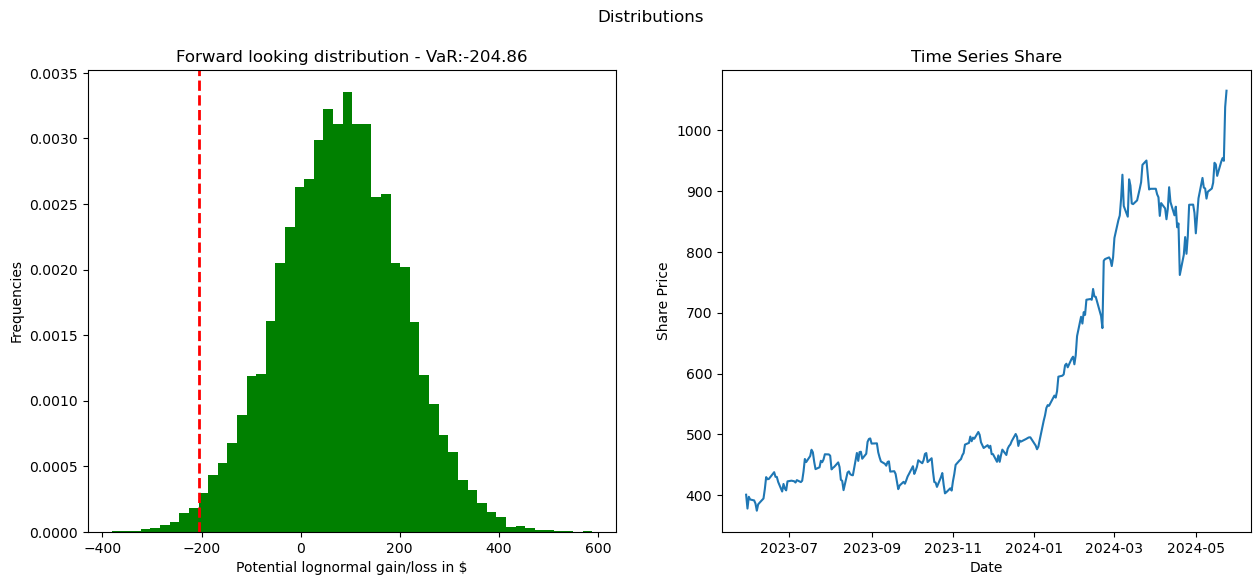

In [270]:
plot_historical_VaR(scenario_return_list,VaR,confidence_interval,days=20, time_series_data = data['Adj Close'])

In [340]:
tickers = ['SPY','NVDA']
weights = np.array([1/len(tickers)]*len(tickers))
weights

array([0.5, 0.5])

In [341]:
data.head()

Price      Adj Close               Close                High              \
Ticker          NVDA         SPY    NVDA         SPY    NVDA         SPY   
Date                                                                       
2014-05-29  4.510177  160.765442  4.7375  192.369995  4.7825  192.399994   
2014-05-30  4.522074  161.024506  4.7500  192.679993  4.7625  192.800003   
2014-06-02  4.507795  161.208328  4.7350  192.899994  4.7950  192.990005   
2014-06-03  4.488755  161.124756  4.7150  192.800003  4.7500  192.899994   
2014-06-04  4.493515  161.450699  4.7200  193.190002  4.7550  193.300003   

Price          Low                Open                Volume            
Ticker        NVDA         SPY    NVDA         SPY      NVDA       SPY  
Date                                                                    
2014-05-29  4.7275  191.330002  4.7425  191.820007  17188400  64377000  
2014-05-30  4.7125  192.029999  4.7375  192.190002  23912800  76316000  
2014-06-02  4.6950  191.970001  4.7650  192.949997  18150000  64656000  
2014-06-03  4.6525  192.250000  4.7450  192.429993  24321200  65047000  
2014-06-04  4.7000  192.270004  4.7025  192.470001  16123600  55529000

In [ ]:
pf_price[] = data.loc[

In [346]:
portfolio = data['Adj Close']['NVDA']*1/len(ticker)+data['Adj Close']['SPY']*1/len(ticker)

Date
2014-05-29     82.637809
2014-05-30     82.773290
2014-06-02     82.858062
2014-06-03     82.806756
2014-06-04     82.972107
                 ...    
2024-05-20    738.929993
2024-05-21    742.609985
2024-05-22    739.665009
2024-05-23    781.975006
2024-05-24    797.064972
Length: 2516, dtype: float64